# Dataprojekt Del 2
Denna notebook utgör den avslutande delen av det egna projektet (Del 2) och innehåller följande steg:
- Data Pre-Processing: 
    - Sammanslagning av data av samma typ men för olika tidsperioder
    - Borttagning av dubbletter efter sammanslagning
    - Konvertering av relevanta fält till passande datatyp
    - Merge av data för `Nederbördstyp` (från nu refererat till som 'typ'), `Relativ luftfuktighet`(luftfuktighet) och max och min `Lufttemperatur` ('temp') till ett kombinerat dataset, `Datum` och `Tid` användes som nyckel/join-villkor.  
- Data Exploration 
    - Plottning av kombinerat dataset för att säkerställa att data inte innehöll outliners eller att data fattades
- ML Training, Testing and Validation
    - Val av algoritmer 
    - Uppdelning av dataset i tränings och validerings data 
    - Test och utvärdering av olika modeller 
- Förbättringsåtgärder 
    - Iterering, förbättringsåtgärder baserat på utfall av föregående steg
- Future steps
    - Förslag på framtid aktiviteter för att förbättra modell 


Data källa: SMHI's väderstation _Stockholm-Observatoriekullen_.

In [36]:
# Import av nödvändiga bibliotek 
import pandas as pd # för data processing
import seaborn as sns # för visualisering
import matplotlib.pyplot as plt 
from matplotlib import style 
style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (16, 7)

# Scikit learn (För ML)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier



/var/folders/w0/pb8x4cmj0lz48d22c6b71j5w0000gn/T/ipykernel_65435/4221362074.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-whitegrid')


In [2]:
# Read CSV files

# TEMP
temp_12h = pd.read_csv('Del2_MetroData/Temp/smhi_lufttemperatur_minMax_12h.csv')
temp_12h_4m = pd.read_csv('Del2_MetroData/Temp/smhi_lufttemperatur_minMax_12h_4m.csv')
# TYP
type_12h  = pd.read_csv('Del2_MetroData/Nederbördstyp/smhi_nederbördstyp_12h.csv')
type_12h_4m  = pd.read_csv('Del2_MetroData/Nederbördstyp/smhi_nederbördstyp_12h_4m.csv')

# LUFT FKT 
humidity_h = pd.read_csv('Del2_MetroData/Luftfuktighet/smhi_relativ_luftfuktighet_h.csv')
humidity_h_4m = pd.read_csv('Del2_MetroData/Luftfuktighet/smhi_relativ_luftfuktighet_h_4m.csv')

## Data Pre-Processing

In [3]:
# Concat - Sammanslagning av dataframes

#TEMP
temp_frames = [temp_12h, temp_12h_4m]
temp = pd.concat(temp_frames)
temp_shape = temp.shape

#TYPE
type_frames = [type_12h, type_12h_4m]
type = pd.concat(type_frames)
type_shape = type.shape

#LUFT FKT 
humidity_frames = [humidity_h, humidity_h_4m]
humidity = pd.concat(humidity_frames)
humidity_shape = humidity.shape

# Control
print(f'Shape - Temp: {temp_shape},Type:{type_shape}, Luft fkt: {humidity_shape}')


Shape - Temp: (44206, 6),Type:(846, 4), Luft fkt: (231647, 4)


In [4]:
# Borttagning av dubbletter efter sammanslagning 
temp = temp.drop_duplicates()
type = type.drop_duplicates()
humidity = humidity.drop_duplicates()

# Control
temp_shape = temp.shape
type_shape = type.shape
humidity_shape = humidity.shape

print(f'Shape - Temp: {temp_shape},Type:{type_shape}, Luft fkt: {humidity_shape}')

Shape - Temp: (44151, 6),Type:(820, 4), Luft fkt: (230993, 4)


In [5]:
temp.dtypes

Datum                object
Tid (UTC)            object
Lufttemperatur      float64
Kvalitet             object
Lufttemperatur.1    float64
Kvalitet.1           object
dtype: object

In [6]:
# Konvertering av data type för samtliga Datum
temp['Datum'] = pd.to_datetime(temp['Datum'])
type['Datum'] = pd.to_datetime(type['Datum'])
humidity['Datum'] = pd.to_datetime(humidity['Datum'])

# Control
temp.dtypes
type.dtypes
humidity.dtypes

Datum                    datetime64[ns]
Tid (UTC)                        object
Relativ Luftfuktighet             int64
Kvalitet                         object
dtype: object

`temp` och `type`s värden är uppmätta vid 18:00:00 och 06:00:00 medan `humidity` är uppmätt varje timme (se kommande 3 celler celler). Genom att göra en merge på "Datum" och "Tid (UTC)" fås data för samma point in time. Som det observerades i inledande data exploration (Del 1) kommer dataframen `Type` att styra längden på tidsperioden eftersom detta är det minsta (och nyaste datasetet).

In [7]:
temp["Tid (UTC)"].value_counts()

Tid (UTC)
18:00:00    22776
06:00:00    21375
Name: count, dtype: int64

In [8]:
type["Tid (UTC)"].value_counts()

Tid (UTC)
18:00:00    420
06:00:00    400
Name: count, dtype: int64

In [9]:
humidity["Tid (UTC)"].value_counts()

Tid (UTC)
04:00:00    9638
20:00:00    9636
22:00:00    9635
01:00:00    9635
21:00:00    9635
23:00:00    9634
19:00:00    9633
02:00:00    9633
15:00:00    9633
03:00:00    9632
14:00:00    9631
17:00:00    9630
16:00:00    9629
07:00:00    9629
11:00:00    9626
13:00:00    9625
10:00:00    9624
09:00:00    9623
00:00:00    9621
08:00:00    9618
06:00:00    9612
18:00:00    9606
12:00:00    9590
05:00:00    9584
12:05:00       1
Name: count, dtype: int64

In [10]:
# Merge on ['Datum', 'Tid (UTC)'] för samtliga dataframes --> nycklarna kan återanvändas 

# keys
keys = ['Datum', 'Tid (UTC)']

# merge temp & type
temp_type = pd.merge(temp, type, on=keys)
#temp_type.head()

# merge temp_type med humidity 
df = pd.merge(temp_type, humidity, on=keys)

# Control
df.head()


,Datum,Tid (UTC),Lufttemperatur,Kvalitet_x,Lufttemperatur.1,Kvalitet.1,Nederbörd,Kvalitet_y,Relativ Luftfuktighet,Kvalitet
0,2019-10-07,18:00:00,1.4,G,8.8,G,regn,Y,83,G
1,2019-10-12,06:00:00,8.6,G,11.0,G,regn,Y,92,G
2,2019-10-14,06:00:00,7.6,G,10.7,G,regn,Y,97,G
3,2019-10-14,18:00:00,7.2,G,9.6,G,regn,Y,94,G
4,2019-10-17,06:00:00,6.8,G,8.3,G,regn,Y,97,G


In [11]:
# Drop unnecessary columns for ML (Kvalitet). 
# Som fastslagits i Del 1, bedöms SMHI's självskattning (i egenskap av experter på mätning och tolkning av metrologiskt data) som trovärdig i kombination med good täckning (inga nollvärden för valda data). 
# Eftersom den numeriskt uppmätta data (Temp och Luftfuktighet) har bedömts att ha en övervägande god kvalitet medan den mer subjektiva klassningen av typ en genomgående sämre kvalitet anses dessa inte vara nödvändiga features för ML.
df = df.drop(columns=['Kvalitet_x', 'Kvalitet.1', 'Kvalitet_y', 'Kvalitet'])

# Control
df.head()

,Datum,Tid (UTC),Lufttemperatur,Lufttemperatur.1,Nederbörd,Relativ Luftfuktighet
0,2019-10-07,18:00:00,1.4,8.8,regn,83
1,2019-10-12,06:00:00,8.6,11.0,regn,92
2,2019-10-14,06:00:00,7.6,10.7,regn,97
3,2019-10-14,18:00:00,7.2,9.6,regn,94
4,2019-10-17,06:00:00,6.8,8.3,regn,97


In [12]:
# Rename columns (Lufttemperatur och Lufttemperatur.1) till mer beskrivande namn
df.rename(columns = {'Lufttemperatur':'TempMin', 'Lufttemperatur.1':'TempMax'}, inplace = True)

# control
df.head()

,Datum,Tid (UTC),TempMin,TempMax,Nederbörd,Relativ Luftfuktighet
0,2019-10-07,18:00:00,1.4,8.8,regn,83
1,2019-10-12,06:00:00,8.6,11.0,regn,92
2,2019-10-14,06:00:00,7.6,10.7,regn,97
3,2019-10-14,18:00:00,7.2,9.6,regn,94
4,2019-10-17,06:00:00,6.8,8.3,regn,97


In [13]:
# Lägger till månads-data för ytterligare aggregering 
df['Month'] = df['Datum'].dt.month_name()

# Control
df.head()


,Datum,Tid (UTC),TempMin,TempMax,Nederbörd,Relativ Luftfuktighet,Month
0,2019-10-07,18:00:00,1.4,8.8,regn,83,October
1,2019-10-12,06:00:00,8.6,11.0,regn,92,October
2,2019-10-14,06:00:00,7.6,10.7,regn,97,October
3,2019-10-14,18:00:00,7.2,9.6,regn,94,October
4,2019-10-17,06:00:00,6.8,8.3,regn,97,October


---
## Data Exploration av sammanslaget och tvättat data
Sammanslaget data undersöks närmare (både via aggregering och visuellt) för att identifiera obalanser i data setet, outliners, dataluckor, etc. som inte kunde observeras när grunddata undersökte var för sig under den explorativa data analysen i __Del 1__.

In [14]:
# Aggregering av labels - undersöker fördelning av typ i datasetet 
df['Nederbörd'].value_counts()

# --> Obalanserad fördelning av klasser i datasetet 

Nederbörd
regn                       510
duggregn                   100
snowfall                    98
regnskurar                  47
snöblandat regn             42
snöbyar                     13
snöhagel                     4
byar av snöblandat regn      2
kornsnö                      2
småhagel                     2
Name: count, dtype: int64

In [15]:
# Aggregering av data punkter per månad  
df.Month.value_counts()

# --> Det kan observeras att månaderna kring årsskiftet har flest uppmätningar av nederbörd. Detta skulle kunna medföra en data obalans där modellen kan få svårare att klassificera nederbörd under t.e.x varma sommarmånader. 

Month
December     115
November     102
October       92
January       90
February      75
May           64
March         56
July          55
April         52
August        44
September     39
June          36
Name: count, dtype: int64

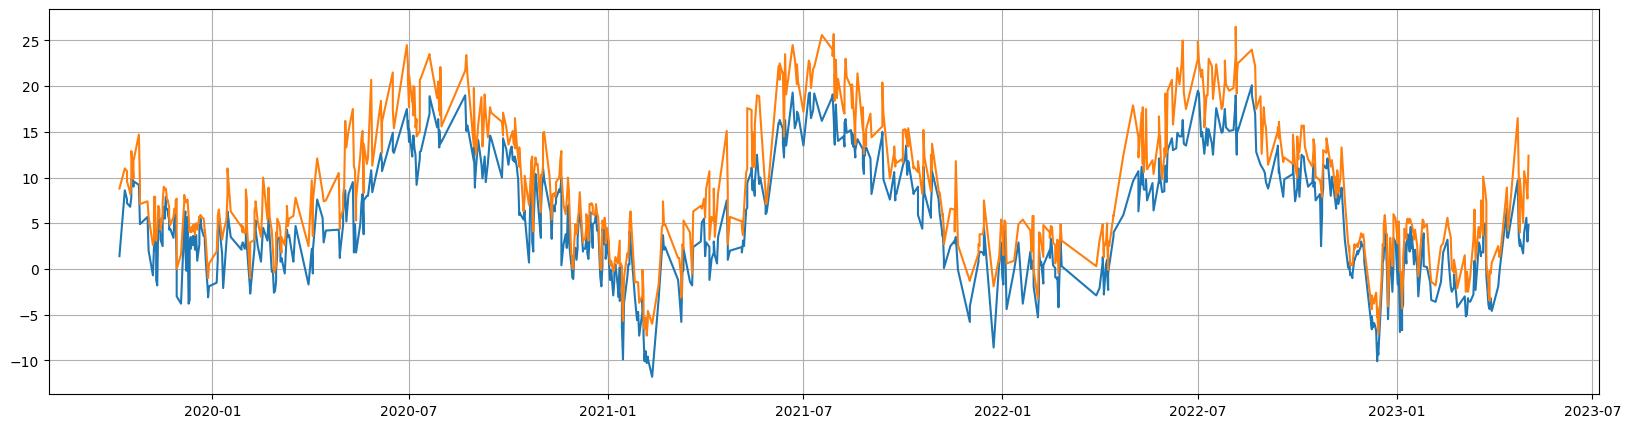

In [16]:
# Plot över tid för att säkerställa att data inte innehåller några extrem värden (outliners) eller att datapunkter fattas

plt.figure(figsize = (20, 5))
fig = plt.plot(df['Datum'], df[['TempMin', 'TempMax']])
plt.grid();

# ---> Plot visar som förvänta på cykliskt data med kallaste temp vid månaderna kring årsskiftet och varmast kring högsommar (juli-aug). 

---
### Scatter Plots 
Scatter plots för att identifiera potentiella kluster samt verifiera hypotes av metrologiska faktorerar bakom snö _(se litteraturstudie i README)_ 

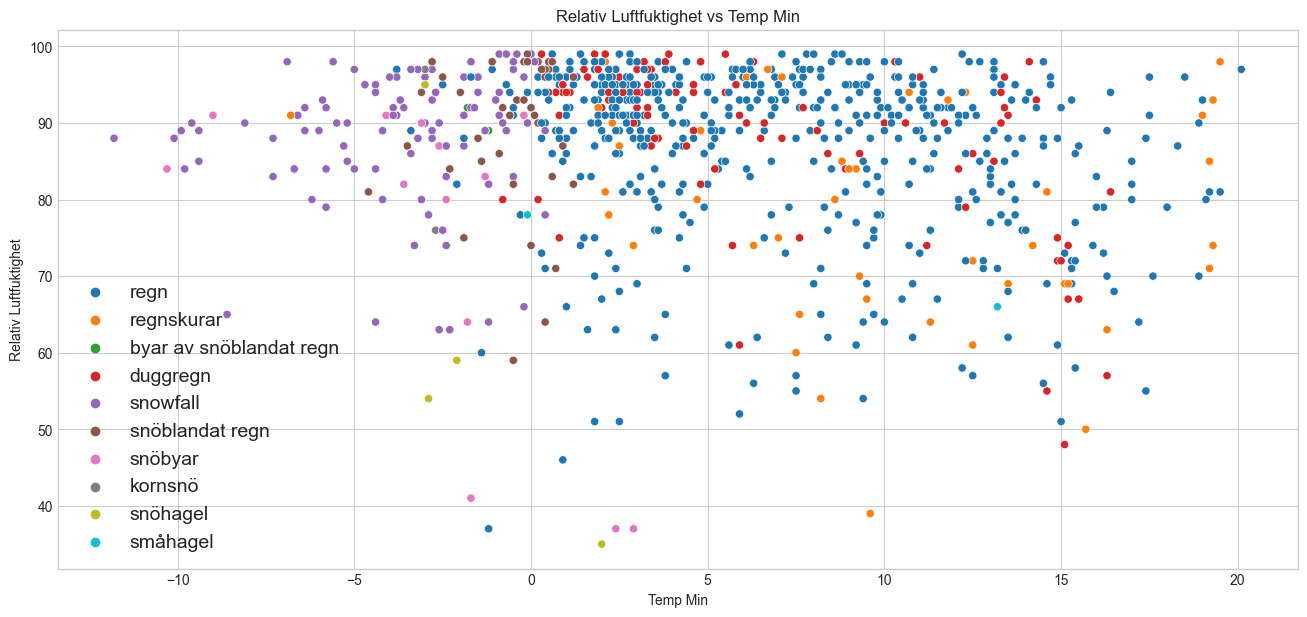

In [38]:
# Scatter plot 1 (Temp Min vs Luftfuktighet)
sns.scatterplot(x='TempMin', y='Relativ Luftfuktighet', data=df, hue="Nederbörd")
plt.title('Relativ Luftfuktighet vs Temp Min')
plt.xlabel('Temp Min')
plt.ylabel('Relativ Luftfuktighet')
plt.legend(fontsize=14)

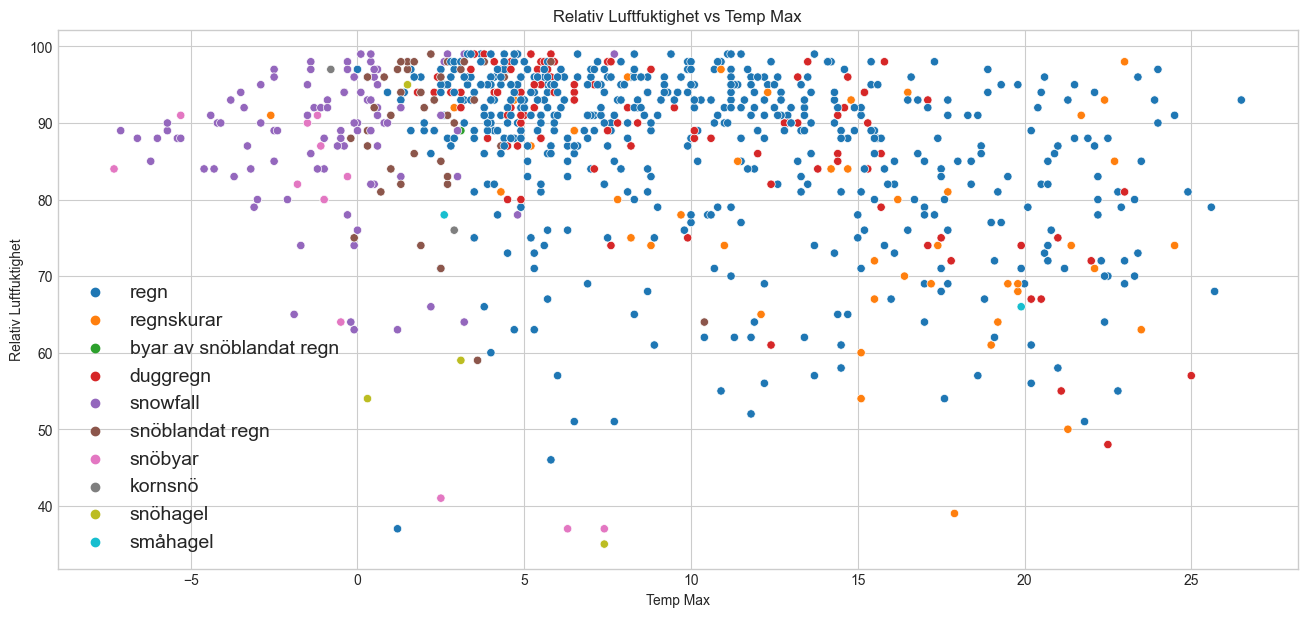

In [39]:
## Scatter plot 2 (Temp Max vs Luftfuktighet)
sns.scatterplot(x='TempMax', y='Relativ Luftfuktighet', data=df, hue="Nederbörd")
plt.title('Relativ Luftfuktighet vs Temp Max')
plt.xlabel('Temp Max')
plt.ylabel('Relativ Luftfuktighet')
plt.legend(fontsize=14)

#### Från scatter plots 1 & 2 (Temp data vs Luftfuktighet) ses liknande trender:

- Nederbörd som klassas som någon typ av snö fås i regel för temperaturer under och kring 0°C
- I enlighet med litteraturstudien ses:
    - sambandet mellan hög luftfuktighet och snö
    - att snö är typiskt förekommande för kring -9°C eller varmare.
- Snöblandat regn förekommer mellan "grupperingen" av nederbörd av någon form av snö och någon form av regn, kring eller något över 0°C.
- Trender ses, men mycket överlapp mellan "snarlika" typer av nederbörd (e.g. duggregn, regnskurar och regn)
- Snöhagel och småhagel har få och spridda punkter, vilket gör det svårt att både se trender för samt träna modellen för denna typ av nederbörd.
---

### Scatter Matrix
Scatter Matris för att identifiera korrelation/relation mellan variabler i datasetet.

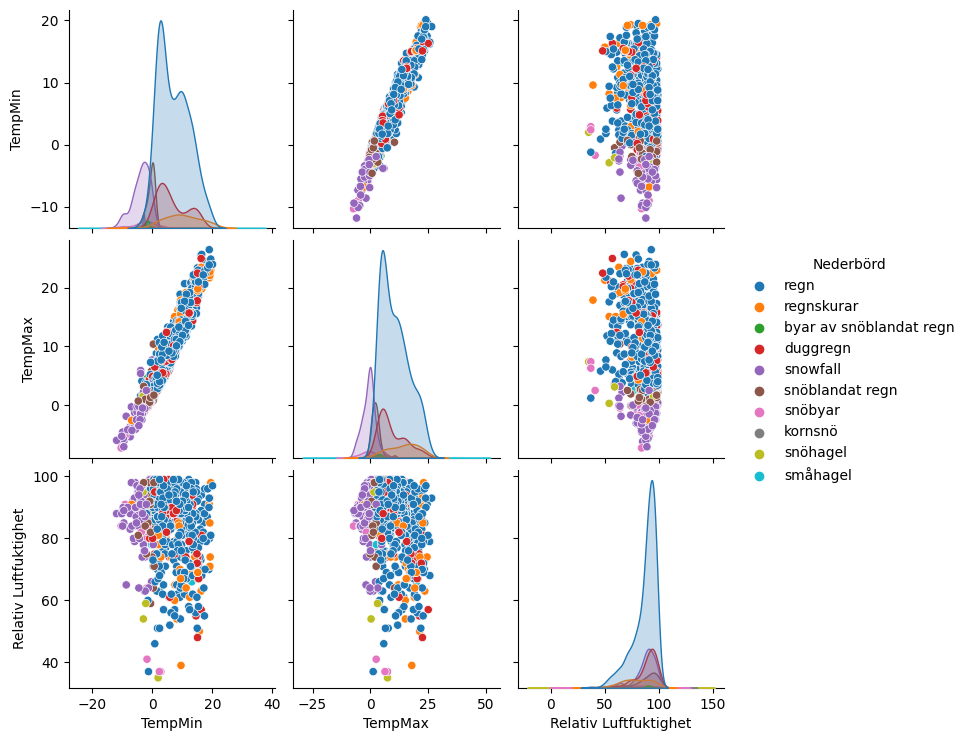

In [19]:
sns.pairplot(data = df, hue = 'Nederbörd')

#### Från Scatter Matrix observeras:
- Liknande trender som för scatter plots
    - Övervägande datapunkter för regn
    - Snöfall fås generellt för lägre temp
    - Snöblandat regn överlappar gränslandet mellan snöfall och regn (vs temp)
    - Snöfall mer beroende av högre luftfuktighet (ca 80-100) än regn som har en större utbredning (ca 50 - 100) om än peakar på likande nivåer som snöfall
    - hagel ev. mer förekommande vid lägre luftfuktighet (för få datapunkter för att kunna valideras)

---
### Heatmap
Heatmap för att identifiera korrelation/relation mellan data variabler. För att studera förhållandet mellan Temp och Luftfuktighet tas övriga datafält bort.

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'TempMin'),
  Text(0, 1.5, 'TempMax'),
  Text(0, 2.5, 'Relativ Luftfuktighet')])

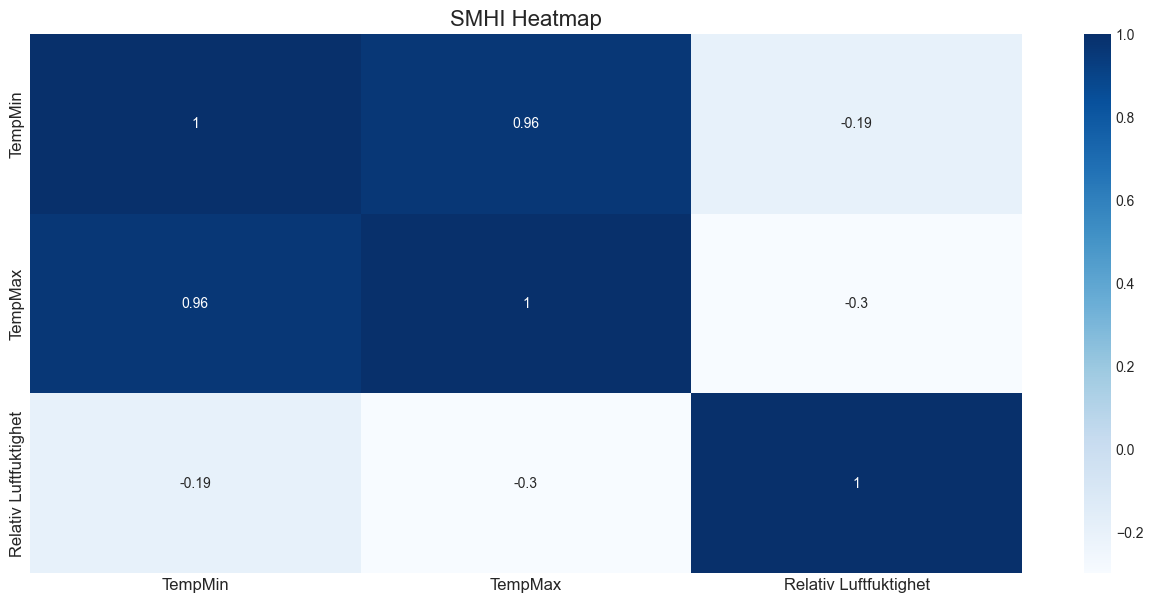

In [40]:
df_heatmap = df.copy()
df_heatmap = df_heatmap.drop(columns=['Datum', 'Tid (UTC)', 'Month', 'Nederbörd'])
df_corr = df_heatmap.corr()

sns.heatmap(df_corr, cmap = 'Blues', annot = True, xticklabels = df_corr.columns.values, yticklabels = df_corr.columns.values)
plt.title('SMHI Heatmap', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

Observerad korrelation: TempMax och Min har hög överensstämmelse, vilket är rimligt då båda mäter samma typ av data (Temp i grader C) under samma tidsintervall. Ev hade en temp variable räckt (t.ex. ett medelvärde av min och max), optimalt hade varit en temp variabel som hade uppmäts samtidigt som nederbörds typ registrerades.   

---
# Träning av ML modell

In [21]:
# Konvertera Nederbörd (klassen vi vill använda för ML) från data type object till int
df_ML = df.copy()
df_ML['Nederbörd']=LabelEncoder().fit_transform(df_ML['Nederbörd'])

# Control
df_ML.head()

,Datum,Tid (UTC),TempMin,TempMax,Nederbörd,Relativ Luftfuktighet,Month
0,2019-10-07,18:00:00,1.4,8.8,3,83,October
1,2019-10-12,06:00:00,8.6,11.0,3,92,October
2,2019-10-14,06:00:00,7.6,10.7,3,97,October
3,2019-10-14,18:00:00,7.2,9.6,3,94,October
4,2019-10-17,06:00:00,6.8,8.3,3,97,October


#### Val av Algoritmer
Problem typ: Klassificering

Val:
1. __Algoritm 1: K-Nearest Neighbors (KNN) Classifier__
    - Huvudalgoritm: Eftersom det tvättade datasetet är relativt litet (820 reader) och icke-linjärt problem av typ Klassificering anses KNN vara en lämplig algoritm.
1. __Algoritm 2: Random Forest__
    - Jämförelse algoritm till algoritm 1. Även lämpad för klassificering av icke-linjära problem och hantera fall då data saknas. 

#### Träning, testning, utvärdering av av utvalda algoritmer

In [22]:
# Val av features (X variable)
features=['TempMax', 'TempMin', 'Relativ Luftfuktighet']
X=df_ML[features]

# Val av variabel för klassificering 
y=df_ML.Nederbörd

# Split av data: test och träning med hjälp av train_test_split-funktionen. Train size > Test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Control 
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Train set shape: (574, 3)
Test set shape: (246, 3)


In [23]:
# K-Nearest Neighbors Classifier

# Träning 
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predict labels för test set
y_pred_knn = knn.predict(X_test)

# Test av accuracy 
accuracy = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {round(accuracy*100)}%')


KNN Accuracy: 68%


In [24]:
# Random forest classifier

# Träning med 100 trees
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0)
clf_rf.fit(X_train, y_train)

# Predict labels för test set
y_pred_rf = clf_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random forest Accuracy: {round(accuracy*100)}%')

Random forest Accuracy: 68%


#### Confusion Matrix - Ytterligare utvärdering av resultat
För att identifiera i vilka fall modellen haft fel

In [25]:
# Confusion Matrix 
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("KNN Confusion Matrix:")
print(cm_knn)

print("Random forest Confusion Matrix:")
print(cm_rf)


KNN Confusion Matrix:
[[  4   0  21   1   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [ 18   0 140   2   0   2   4   0   0]
 [  0   0   9   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   2   0   0  23   0   0   0]
 [  0   0   7   0   0   5   0   0   0]
 [  0   0   2   0   0   3   0   0   0]
 [  0   0   1   0   0   0   0   0   0]]
Random forest Confusion Matrix:
[[  4   0  21   1   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]
 [ 14   0 143   4   0   1   4   0   0]
 [  0   0   9   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   2   0   0  21   2   0   0]
 [  0   0   5   0   0   7   0   0   0]
 [  0   0   1   0   0   3   0   0   1]
 [  0   0   0   0   0   1   0   0   0]]


Bägge modeller får likande (avrundat) Accuarcy score, och liknande (men inte identiska) confusion matrix. Problem med att modellen misstar snarlika typer, e.g. olika typer av regn.

---
## Förbättring av resultat
Försök att förbättra resultat genom ytterligare tvättning av data. Hypotes att Aggregering av "regn" och "snö" typ kommer leda till färre "falska" resultat (e.g, modellen klassificerade det som regn när det egentligen var duggregn). 

OBS. följande data grupperas separat utanför snö-regn-aggregering:
-  `Hagel` p.g.a "outliner data" i förhållande till både snö och regn, få datapunkter. 
- `Sböblandat regn` p.g.a mellanting av snö och regn, relativt stor mängd datapunkter (i förhållande till snö), samt "tydligt" om än överlappande kluster med regn och snö. 


In [26]:
# Innan aggregering 
df.Nederbörd.value_counts()

Nederbörd
regn                       510
duggregn                   100
snowfall                    98
regnskurar                  47
snöblandat regn             42
snöbyar                     13
snöhagel                     4
byar av snöblandat regn      2
kornsnö                      2
småhagel                     2
Name: count, dtype: int64

In [27]:
df_ag = df.copy()

# Lookup - definiera gamla och nya värden i ett dictionary
type_lookup = {
    'regn': 'regn',
    'duggregn': 'regn',
    'regnskurar': 'regn',
    'snowfall': 'snö',
    'snöbyar': 'snö',
    'kornsnö': 'snö',
    'snöhagel': 'hagel',
    'småhagel': 'hagel',
    'snöblandat regn': 'snöblandat regn',
    'byar av snöblandat regn': 'snöblandat regn'
}

# Ersätter de gamla värdena i kolumnen "Nederbörd"
df_ag['Nederbörd'] = df_ag['Nederbörd'].replace(type_lookup)

# Control - efter aggregering 
df_ag.Nederbörd.value_counts()

Nederbörd
regn               657
snö                113
snöblandat regn     44
hagel                6
Name: count, dtype: int64

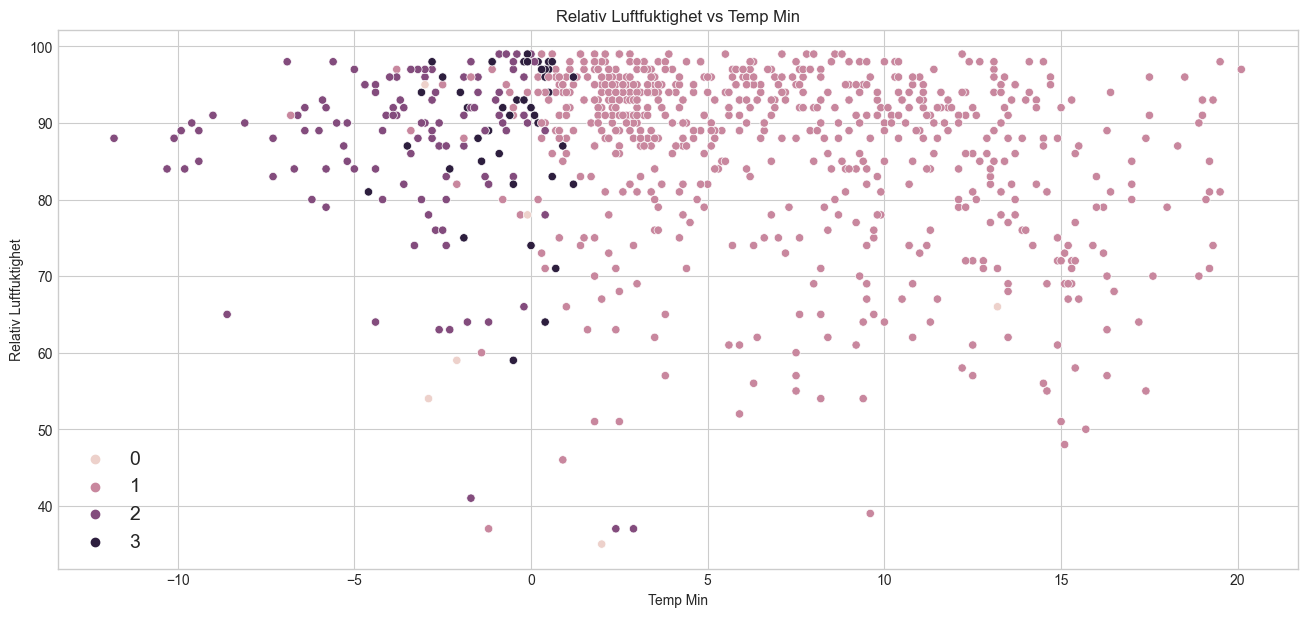

In [41]:
# Scatter plot 3 (Temp Min vs Luftfuktighet)
sns.scatterplot(x='TempMin', y='Relativ Luftfuktighet', data=df_ag, hue="Nederbörd")
plt.title('Relativ Luftfuktighet vs Temp Min')
plt.xlabel('Temp Min')
plt.ylabel('Relativ Luftfuktighet')
plt.legend(fontsize=14)

#### Från Scatter Plot 3 fås
- Aggregerat data ger tydligare kluster
- Tydligt obalanserat dataset --> även om obalanserat dataset (övervägande regn tyo) bedöms den tydliga korrelationen mellan temperatur i kombinnation med luftfuktighet och typ kunna ge en bra model. 


In [29]:
# Träning baserat på aggregerade data
# Data pre-processing: label (object) --> int
df_ag['Nederbörd']=LabelEncoder().fit_transform(df_ag['Nederbörd'])

# val X och y var
features=['TempMax', 'TempMin', 'Relativ Luftfuktighet']
X=df_ag[features]
y=df_ag.Nederbörd

# Split av dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# träning pch test enbart på KNN då denna gav snarlikt resultat som Random Forest 
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_knn)

# Accuracy med aggregerat data
print(f'KNN Accuracy: {round(accuracy*100)}%')


KNN Accuracy: 90%


KNN Accuracy ökade från ca 70 % --> ca 90%, samma model, features, test_size, etc. Enbart uppdatering gjord på datanivå (tydligare kluster pga färre klasser)

In [30]:
# Predict the labels for the test set
y_pred = knn.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  0   2   0   0]
 [  0 196   2   3]
 [  0   4  26   1]
 [  0   7   5   0]]


Tydlig förbättring av Confusion Matrix resultat. Som förväntat är snöblandat regn och hagel fortsatt svårt att förutse pga:
1. mindre dataset (speciellt för hagel)
2. Naturligt överlapp mellan kluster (e.g. snöblandat regn = blandning av snö och regn till sin natur)

---
## Future steps
- __Balansering och utökning av dataset__: Då modellen begränsades av mängden klassificerat data hade "mockat" snödata kunnat genereras från historisk `TempMax`, `TempMin` och `Relativ Luftfuktighets` data baserat på faktorena nämnda i litteraturstudien. Därefter hade en ny träning på ett mer balanserat och utökat dataset kunnat göras (flera årtionden bakåt i tiden). Alternativt hade SMHI-data från fler väderstationer i Stockholms omnejd (eller i resterande landet) kunnat undersökas och ev, användas för att balansera upp modellen.

- __Addera Nederbördsmängd data__: Det tänkta datasetet _Nederbördsmängd_ (tomt dataset undersökt i Del 1) hade troligen hjälpt modellen att skilja på snarlika nederbördstyper som till sin natur skiljs åt baserat på "mängd"/"intensitet" fallande nederbörd (t.ex. duggregn vs regnskurar). Det är troligt att denna data finns för någon av SMHI's övriga väderstationer och hade kunnat användas som komplement i modellen. 

- __Addering av ytterligare typer__: Modellen bör utökas med klassificerat data för väder utan nederbörd (t.ex. molnigt, soligt, etc.), nuvarande modell kommer oavsett "egentligt" värden klassificera inputen som någon form av nederbörd, vilket inte är ett användbart use case i verkligheten. Alternativt hade någon form av binär uppskattning/sannolikhet för nederbörd eller inte nederbörd kunna användas i kombination med uppskattning av typ.

- __Addering av ytterligare algoritmer__: Jämförelse mot ytterligare klassificerings algoritmer och tweakning av dessa (e.g test size, antal träd, mm.). Under testning kunde bl.a observeras att random forest i vissa fall presterade bättre än KNN (1-2%) för både mindre och större test size (men ingen konsekvent trend kunde observeras), detta kan vara relateras till att datasetet är obalanserat och random forest är en passande algoritm för att hantera fall då data saknas. Då bägge undersökta algoritmer gav snarlika resultat hade det varit intressant att jämföra ytterligare alternativ samt se hur samtliga påverkas av ett utökat och mer balanserat dataset.

- __"Produktifiering"__: Göra en mer "användbar produkt" (utifrån mål och problemställning) som hade kunnat användas för att i god tid förutse nederbörd --> t.ex. genom att ta fram en regressions modell för att "förutspå" metrologiskt data (TempMax, TempMin, Relativ Luftfuktighet, etc.) en vecka framåt och sedan använda dessa för att förutspå typ av nederbörd/risk för nederbörd.

- __Addering av ytterligare features__: Addering av ytterligare meteorlogiskt data från SMHI t.e.x vindhastighet, molnmängd, lufttryck, etc. Och undersöka hur detta påverkar modellen.    
